# Tutorial: Transformers, Vision Transformers and applications

**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1u-i9Xmzx8rhlp0oekFo9SdaCiz9t91Wu#scrollTo=JlTnRt83cy0D)  
**Pre-trained models:**
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial6)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1DF7POc6j03pRiWQPWSl5QJX5iY-xK0sV?usp=sharing)   
**Recordings:**

**Author:** Simon Dahan

In this tutorial, we will discuss one of the major deep learning architectures of the past years: the Transformers models. This tutorial is greatly inspired by the [*UVA Deep Learning Notebooks*](https://uvadlc-notebooks.readthedocs.io/en/latest/), particularly the [*Tutorial 6*](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb#scrollTo=1hkNROGHXvaz) and [*Tutorial 15*](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial15/Vision_Transformer.ipynb#scrollTo=DbUKvP9NXy-H), with some little twists to adapt to the case of medical imaging.  


# 1. Background

The Transformer architecture was introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al in 2017 in the context of machine translation and other Natural Language Processing (NLP) tasks. Transformer models have revolutionised the NLP field, surpassing the popular RNN and LSTM architectures, by allowing to process very long sequences while preserving a large context. This is partly due to the attention mechanisms, that will be detailed in this tutorial. Today, the Transformer models are the backbone of many popular Large Language Models such as GPT models [Radford et al 2019](https://insightcivic.s3.us-east-1.amazonaws.com/language-models.pdf), but have also been adapted to other domains as agnostic-domain architecture, such as in computer vision with the Vision Transformers.

In [22]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

os.makedirs('./data', exist_ok=True)

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


<ipython-input-22-988b35fb7ff0>:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

# 1. The Transformer Architecture

In the first part of this notebook, we will implement the Transformer architecture by hand. As the architecture is so popular, there already exists a Pytorch module `nn.Transformer` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)) and a [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) on how to use it for next token prediction. However, we will implement it here ourselves, to get through to the smallest details.

There are of course many more tutorials out there about attention and Transformers. Below, we list a few that are worth exploring if you are interested in the topic and might want yet another perspective on the topic after this one:

* [Transformer: A Novel Neural Network Architecture for Language Understanding (Jakob Uszkoreit, 2017)](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) - The original Google blog post about the Transformer paper, focusing on the application in machine translation.
* [The Illustrated Transformer (Jay Alammar, 2018)](http://jalammar.github.io/illustrated-transformer/) - A very popular and great blog post intuitively explaining the Transformer architecture with many nice visualizations. The focus is on NLP.
* [Attention? Attention! (Lilian Weng, 2018)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) - A nice blog post summarizing attention mechanisms in many domains including vision.
* [Illustrated: Self-Attention (Raimi Karim, 2019)](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a) - A nice visualization of the steps of self-attention. Recommended going through if the explanation below is too abstract for you.
* [The Transformer family (Lilian Weng, 2020)](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html) - A very detailed blog post reviewing more variants of Transformers besides the original one.

### What is Attention?

The attention mechanism describes a recent new group of layers in neural networks that has attracted a lot of interest in the past few years, especially in sequence tasks. There are a lot of different possible definitions of "attention" in the literature, but the one we will use here is the following: _the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements' keys_. So what does this exactly mean? The goal is to take an average over the features of multiple elements. However, instead of weighting each element equally, we want to weight them depending on their actual values. In other words, we want to dynamically decide on which inputs we want to "attend" more than others. In particular, an attention mechanism has usually four parts we need to specify:

* **Query**: The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
* **Keys**: For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is "offering", or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
* **Values**: For each input element, we also have a value vector. This feature vector is the one we want to average over.
* **Score function**: To rate which elements we want to pay attention to, we need to specify a score function $f_{attn}$. The score function takes the query and a key as input, and output the score/attention weight of the query-key pair. It is usually implemented by simple similarity metrics like a dot product, or a small MLP.


The weights of the average are calculated by a softmax over all score function outputs. Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query. If we try to describe it with pseudo-math, we can write:

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Visually, we can show the attention over a sequence of words as follows:

<center width="100%" style="padding:25px"><img src="attention_example.svg" width="750px"></center>

For every word, we have one key and one value vector. The query is compared to all keys with a score function (in this case the dot product) to determine the weights. The softmax is not visualized for simplicity. Finally, the value vectors of all words are averaged using the attention weights.

Most attention mechanisms differ in terms of what queries they use, how the key and value vectors are defined, and what score function is used. The attention applied inside the Transformer architecture is called **self-attention**. In self-attention, each sequence element provides a key, value, and query. For each element, we perform an attention layer where based on its query, we check the similarity of the all sequence elements' keys, and returned a different, averaged value vector for each element. We will now go into a bit more detail by first looking at the specific implementation of the attention mechanism which is in the Transformer case the scaled dot product attention.

### Scaled Dot Product Attention

The core concept behind self-attention is the scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$ and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric. In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="scaled_dot_product_attn.svg" width="210px"></center>

One aspect we haven't discussed yet is the scaling factor of $1/\sqrt{d_k}$. This scaling factor is crucial to maintain an appropriate variance of attention values after initialization. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma^2$ results in a scalar having $d_k$-times higher variance:

$$q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma^4\cdot d_k$$


If we do not scale down the variance back to $\sim\sigma^2$, the softmax over the logits will already saturate to $1$ for one random element and $0$ for all others. The gradients through the softmax will be close to zero so that we can't learn the parameters appropriately. Note that the extra factor of $\sigma^2$, i.e., having $\sigma^4$ instead of $\sigma^2$, is usually not an issue, since we keep the original variance $\sigma^2$ close to $1$ anyways.

The block `Mask (opt.)` in the diagram above represents the optional masking of specific entries in the attention matrix. This is for instance used if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value.

After we have discussed the details of the scaled dot product attention block, we can write a function below which computes the output features given the triple of queries, keys, and values:

In [13]:
def scaled_dot_product(q, k, v):
    #embedding size for normalisation
    d_k = q.size()[-1]
    #dot products between all query and keys pairs
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    #normalisation
    attn_logits = attn_logits / math.sqrt(d_k)
    #apply softmax to obtain attention score
    attention = F.softmax(attn_logits, dim=-1)
    #use the attention scores to weights the contribution of value tokens
    #to genereate the new sequence
    values = torch.matmul(attention, v)

    return values, attention

Note that our code above supports any additional dimensionality in front of the sequence length so that we can also use it for batches. However, for a better understanding, let's generate a few random queries, keys, and value vectors, and calculate the attention outputs:

In [14]:
seq_len = 3
emb_dim = 2

q = torch.randn(seq_len, emb_dim)
k = torch.randn(seq_len, emb_dim)
v = torch.randn(seq_len, emb_dim)

values, attention = scaled_dot_product(q, k, v)

In [15]:
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.9895, -0.5037],
        [ 0.1968,  0.2699],
        [ 1.2049,  0.8960]])
K
 tensor([[-0.3361,  0.8859],
        [ 0.8878,  0.5791],
        [-0.8981,  0.9985]])
V
 tensor([[ 0.6159, -0.5734],
        [ 0.2725, -1.4613],
        [-0.4329, -2.1058]])
Values
 tensor([[ 0.2458, -1.3513],
        [ 0.1670, -1.3702],
        [ 0.2410, -1.3466]])
Attention
 tensor([[0.2339, 0.6144, 0.1517],
        [0.3265, 0.3651, 0.3085],
        [0.2499, 0.5838, 0.1663]])


### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and $W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="./illustrations/multihead_attention.svg" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network, where we don't have an arbitrary query, key, and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

In [16]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x,  return_attention=False):

        batch_size, seq_length, _ = x.size()

        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

One crucial characteristic of the multi-head attention is that it is permutation-equivariant with respect to its inputs. This means that if we switch two input elements in the sequence, e.g. $X_1\leftrightarrow X_2$ (neglecting the batch dimension for now), the output is exactly the same besides the elements 1 and 2 switched. Hence, the multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable! But what if the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look at later (topic _Positional encodings_ below).

Before moving on to creating the Transformer architecture, we can compare the self-attention operation with our other common layer competitors for sequence data: convolutions and recurrent neural networks. Below you can find a table by [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762) on the complexity per layer, the number of sequential operations, and maximum path length. The complexity is measured by the upper bound of the number of operations to perform, while the maximum path length represents the maximum number of steps a forward or backward signal has to traverse to reach any other position. The lower this length, the better gradient signals can backpropagate for long-range dependencies. Let's take a look at the table below:


<center width="100%"><img src="./illustrations/comparison_conv_rnn.svg" width="600px"></center>

$n$ is the sequence length, $d$ is the representation dimension and $k$ is the kernel size of convolutions. In contrast to recurrent networks, the self-attention layer can parallelize all its operations making it much faster to execute for smaller sequence lengths. However, when the sequence length exceeds the hidden dimensionality, self-attention becomes more expensive than RNNs. One way of reducing the computational cost for long sequences is by restricting the self-attention to a neighborhood of inputs to attend over, denoted by $r$. Nevertheless, there has been recently a lot of work on more efficient Transformer architectures that still allow long dependencies, of which you can find an overview in the paper by [Tay et al. (2020)](https://arxiv.org/abs/2009.06732) if interested.

### Transformer Encoder

Next, we will look at how to apply the multi-head attention block inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the [BERT](https://arxiv.org/abs/1810.04805)-family, the [Vision Transformer](https://arxiv.org/abs/2010.11929), and more), and in our tutorial, we will also mainly focus on the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well. The full Transformer architecture looks as follows (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

<center width="100%"><img src="transformer_architecture.svg" width="400px"></center>

The encoder consists of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons:

1. Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
2. Without the residual connection, the information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position $i$ has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient and does not have the benefit of the improved gradient flow.

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately. You can imagine as this allows the model to "post-process" the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below. We first start by implementing a single encoder block. Additionally to the layers described above, we will add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

In [17]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`. The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including [Attention is not Explanation](https://arxiv.org/abs/1902.10186) and [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).

In [18]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional encoding

We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. The position information can therefore be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see "Positional encoding"), and constitute the position information. We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

The positional encoding is implemented below. The code is taken from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model) about Transformers on NLP and adjusted for our purposes.

In [19]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

To understand the positional encoding, we can visualize it below. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel, therefore, represents the change of the input feature we perform to encode the specific position. Let's do it below.

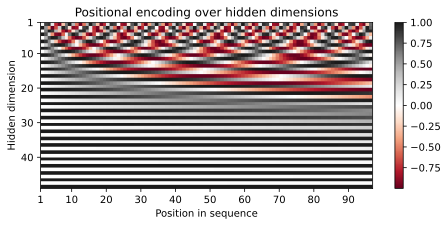

In [20]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

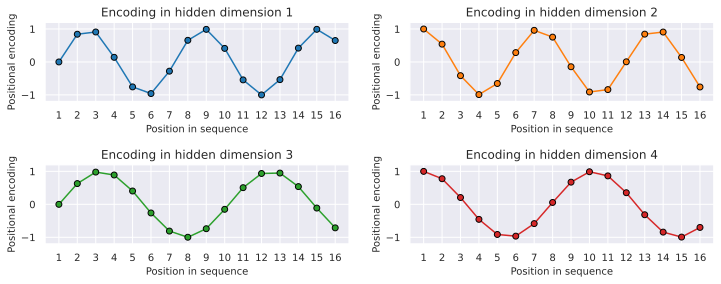

In [21]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

## Experiments

After having finished the implementation of the Transformer architecture, we can start experimenting and apply it to various tasks. In this notebook, we will focus on two tasks: parallel Sequence-to-Sequence, and set anomaly detection. The two tasks focus on different properties of the Transformer architecture, and we go through them below.

### Sequence to Sequence

A Sequence-to-Sequence task represents a task where the input _and_ the output is a sequence, not necessarily of the same length. Popular tasks in this domain include machine translation and summarization. For this, we usually have a Transformer encoder for interpreting the input sequence, and a decoder for generating the output in an autoregressive manner. Here, however, we will go back to a much simpler example task and use only the encoder. Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well.

First, let's create a dataset class below.

In [ ]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

We create an arbitrary number of random sequences of numbers between 0 and `num_categories-1`. The label is simply the tensor flipped over the sequence dimension. We can create the corresponding data loaders below.

# 2. The Vision Transformer Architecture

## Transformers for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, we have simply added a positional encoding to the input feature vectors, and the model learned by itself what to do with it. So, why not do the same thing on images? This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, we split an image of, for example, $48\times 48$ pixels into 9 $16\times 16$ patches. Each of those patches is considered to be a "word"/"token" and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task. A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="vit.gif" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves. First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$. These represent the input words to the Transformer.

# 3. Vision Transformers in Medical Imaging

- MedicalMNIST

# 4. Application: Surface Vision Transformers